# Motion outliers with temporal filtering
AUTHOR : Mike Tyszka  
PLACE  : CBIC  
DATES  : 2021-05-08 JMT Adapt from SOCNSLOI2 filtered FD notebook

Low pass filtering of rigid body registration parameters prior to FD calculation is based on the recommendations in:

J. C. Williams and J. X. Van Snellenberg, “Motion denoising of multiband resting state functional connectivity MRI data: An improved volume censoring method,” bioRxiv, p. 860635, 14-Dec-2019 [Online]. Available: https://www.biorxiv.org/content/10.1101/860635v2.full. [Accessed: 19-May-2020]

D. A. Fair et al., “Correction of respiratory artifacts in MRI head motion estimates,” Neuroimage, vol. 208, p. 116400, Mar. 2020, doi: 10.1016/j.neuroimage.2019.116400. [Online]. Available: http://dx.doi.org/10.1016/j.neuroimage.2019.116400

C. Gratton et al., “Removal of high frequency contamination from motion estimates in single-band fMRI saves data without biasing functional connectivity,” Neuroimage, p. 116866, Apr. 2020, doi: 10.1016/j.neuroimage.2020.116866. [Online]. Available: http://dx.doi.org/10.1016/j.neuroimage.2020.116866

J. D. Power, C. J. Lynch, B. M. Silver, M. J. Dubin, A. Martin, and R. M. Jones, “Distinctions among real and apparent respiratory motions in human fMRI data,” Neuroimage, vol. 201, p. 116041, Nov. 2019, doi: 10.1016/j.neuroimage.2019.116041. [Online]. Available: http://dx.doi.org/10.1016/j.neuroimage.2019.116041

In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd

from glob import glob
from scipy import signal

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import bids
bids.config.set_option('extension_initial_dot', True)

In [5]:
# Create composite dataframe from all MRIQC mocopars
pkl_fname = 'conte_mriqc_mocopars.pkl'

# Core protocol to TR (in seconds) dictionary
TR_dict = {
    'core1p1': 2.5,
    'core1p2': 1.0,
    'core1p3p0': 1.0,
    'core1p3p1': 1.0,
    'core1p4': 1.0,
    'core2p1': 1.0,
    'core2p1p1': 1.0,
    'core2p2': 0.7,
    'coresocbat': 1.0
}

if os.path.isfile(pkl_fname):
    
    print('MRIQC moco parameter dataframe exists - loading')
    
    # Load pickled
    df = pd.read_pickle(pkl_fname)
    
else:
    
    print('Constructing moco parameter dataframe')
    moco_files = sorted(glob(os.path.join('mocopars', '*.1D')))
    
    moco_list = []
    
    for fname in moco_files:
        
        # Parse filename for subject, session, etc
        keys = bids.layout.parse_file_entities(fname)
        
        subj, ses, task, run = keys['subject'], keys['session'], keys['task'], keys['run']
        
        print('  {}-{}-{}-{}'.format(subj, ses, task, run))
        
        TR = TR_dict[ses]
        
        tmp_df = pd.read_csv(
            fname,
            delim_whitespace=True,
            header=None,
            names=['rz_deg', 'rx_deg', 'ry_deg', 'tz_mm', 'tx_mm', 'ty_mm']
        )
        
        moco_list.append([
            subj, ses, task, run, TR,
            tmp_df['tx_mm'], tmp_df['ty_mm'], tmp_df['tz_mm'],
            tmp_df['rx_deg'], tmp_df['ry_deg'], tmp_df['rz_deg']
        ])
        
    # Convert to dataframe
    df = pd.DataFrame(
        moco_list,
        columns=['Subject', 'Protocol', 'Task', 'Run', 'TR_s', 'Tx_mm', 'Ty_mm', 'Tz_mm', 'Rx_deg', 'Ry_deg', 'Rz_deg']
    )
    
    print('Saving moco dataframe as {}'.format(pkl_fname))
    df.to_pickle(pkl_fname)
        
df.head()    

MRIQC moco parameter dataframe exists - loading


,Subject,Protocol,Task,Run,TR_s,Tx_mm,Ty_mm,Tz_mm,Rx_deg,Ry_deg,Rz_deg
0,CC0002,core1p1,loi,1,2.5,0 0.0131 1 0.0262 2 0.0264 3 ...,0 -0.0151 1 -0.0605 2 -0.0310 3 ...,0 -0.0345 1 0.0798 2 0.0893 3 ...,0 -0.0213 1 -0.0214 2 -0.0026 3 ...,0 0.0020 1 0.0138 2 0.0136 3 ...,0 0.0103 1 0.0161 2 0.0134 3 ...
1,CC0002,core1p1,rest,1,2.5,0 0.0136 1 0.0162 2 0.0169 3 ...,0 -0.0409 1 0.0194 2 -0.0839 3 ...,0 -0.0569 1 0.0726 2 0.0109 3 ...,0 -0.1933 1 -0.1411 2 -0.2120 3 ...,0 -0.0070 1 0.0215 2 0.0061 3 ...,0 -0.0296 1 -0.0206 2 -0.0225 3 ...
2,CC0002,core1p1,rest,2,2.5,0 -0.1037 1 -0.0573 2 -0.0402 3 ...,0 0.1734 1 0.0252 2 0.0308 3 ...,0 -0.3190 1 -0.1807 2 -0.1107 3 ...,0 -0.0285 1 -0.0441 2 -0.0703 3 ...,0 -0.0002 1 0.0051 2 0.0080 3 ...,0 -0.0699 1 -0.0427 2 -0.0441 3 ...
3,CC0003,core1p1,loi,1,2.5,0 0.0251 1 0.0199 2 0.0221 3 ...,0 0.0439 1 0.0581 2 0.0311 3 ...,0 -0.1240 1 -0.0768 2 -0.1034 3 ...,0 0.1481 1 0.1829 2 0.2049 3 ...,0 0.0305 1 0.0209 2 0.0321 3 ...,0 0.1276 1 0.1181 2 0.1133 3 ...
4,CC0003,core1p1,rest,1,2.5,0 -0.0455 1 -0.0396 2 -0.0476 3 ...,0 0.0587 1 0.0768 2 0.0456 3 ...,0 -0.0949 1 -0.0764 2 -0.0496 3 ...,0 0.0700 1 0.0808 2 0.0838 3 ...,0 0.0090 1 0.0088 2 0.0045 3 ...,0 -0.0179 1 -0.0127 2 -0.0337 3 ...


## Apply Exclusion Criteria

In [6]:
# Exclude subjects not in FS7 group

# Complete subject list
raw_subj_list = df['Subject'].unique()

# Load FS7 subject list (note 'sub-' prefix used in this file)
fs_subj_df = pd.read_csv('FS7_pass0_subjects.csv', header=None, names=['Subject'])
fs_subj_list = fs_subj_df['Subject'].values

print('Excluding subjects not in FS7 group:')
for subj_id in raw_subj_list:
    full_subj_id = 'sub-' + subj_id
    if full_subj_id not in fs_subj_list:
        print('  {}'.format(subj_id))
        df.drop(index=df[df['Subject'] == subj_id].index, inplace=True)
        
# Exclude unused tasks and sessions
df.drop(df[df['Protocol'] == 'coresocbat'].index, inplace=True)
df.drop(df[df['Task'] == 'loi'].index, inplace=True)
df.drop(df[df['Task'] == 'loi3'].index, inplace=True)
df.drop(df[df['Task'] == 'socnsloi2'].index, inplace=True)

Excluding subjects not in FS7 group:
  CC0084
  CC0088
  CC0092


## Framewise Displacement from MOCO Parameters

In [7]:
# Framewise displacement
def calc_fd(mocopars):
    """
    Calculate conventional FD from 6-column mocopar array (FSL MCFLIRT format)
    Column order: Rx_rad, Ry_rad, Rz_rad, Tx_mm, Ty_mm, Tz_mm
    
    Reference:
    J. D. Power, K. A. Barnes, A. Z. Snyder, B. L. Schlaggar, and S. E. Petersen,
    “Spurious but systematic correlations in functional connectivity MRI networks arise from subject motion,”
    Neuroimage, vol. 59, pp. 2142–2154, Feb. 2012, doi: 10.1016/j.neuroimage.2011.10.018. [Online].
    Available: http://dx.doi.org/10.1016/j.neuroimage.2011.10.018
    """

    # Rotations (radians)
    rx = mocopars[:, 0]
    ry = mocopars[:, 1]
    rz = mocopars[:, 2]

    # Translations (mm)
    tx = mocopars[:, 3]
    ty = mocopars[:, 4]
    tz = mocopars[:, 5]

    # Backward differences (forward difference + leading 0)

    drx = np.insert(np.diff(rx), 0, 0)
    dry = np.insert(np.diff(ry), 0, 0)
    drz = np.insert(np.diff(rz), 0, 0)
    
    dtx = np.insert(np.diff(tx), 0, 0)
    dty = np.insert(np.diff(ty), 0, 0)
    dtz = np.insert(np.diff(tz), 0, 0)
    
    # Total framewise displacement (Power 2012)
    
    r_sphere = 50.0  # mm
    
    FD = (np.abs(dtx) +
          np.abs(dty) +
          np.abs(dtz) +
          np.abs(r_sphere * drx) +
          np.abs(r_sphere * dry) +
          np.abs(r_sphere * drz)
         )
    
    return FD

## Low Pass Butterworth Filter (0.2 Hz)

In [8]:
def butterworth_lpf(TR=0.6, N=5, fc=0.2):

    # Repetition time (s)
    TR = 0.7

    # Sampling rate (Hz)
    fs = 1.0 / TR

    # Butterworth order
    N = 5

    # Critical frequency (Hz - same units as fs)
    fc = 0.2

    # Design filter
    b, a = signal.butter(N, fc, 'low', analog=False, output='ba', fs=fs)

    return b, a

def plot_filter_response(b, a, fs):
    
    # Filter response
    f, h = signal.freqz(b, a, fs=fs)

    plt.semilogx(f, np.abs(h))
    plt.title('Butterworth LPF frequency response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(100, color='green') # cutoff frequency
    plt.show()

In [32]:
# Calculate FD and LPF FD from mocopars

# Init FD stats list
fd_stats_list = []

# Loop over all series
for index, row in df.iterrows():
    
    # Extract mocopars from current dataframe row
    tx_mm, ty_mm, tz_mm = row['Tx_mm'], row['Ty_mm'], row['Tz_mm']
    rx_deg, ry_deg, rz_deg = row['Rx_deg'], row['Ry_deg'], row['Rz_deg']
    
    # Create composite mocopars array (N x 6)
    mocopars = np.array([rx_deg, ry_deg, rz_deg, tx_mm, ty_mm, tz_mm]).transpose()

    # Convert rotation columns from degrees (AFNI) to radians (SPM)
    mocopars[:, 0:3] *= np.pi / 180.0
    
    # Calculate FD from mocopars
    fd = calc_fd(mocopars)

    # Create Butterworth LPF for this TR
    this_tr = row['TR_s']
    b, a = butterworth_lpf(TR=this_tr)
    
    # Low pass filter all timeseries (f < 0.2 Hz)
    mocopars_lpf = signal.filtfilt(b, a, mocopars, axis=0)
    fd_lpf = calc_fd(mocopars_lpf)

    # Plot unfiltered and filtered FD timeseries
    # fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    # t = np.arange(0, len(mcf))
    # axs[0].plot(t, fd)
    # axs[1].plot(t, fd_lpf)
    # plt.show()
    
    # Record median and 95th percentile FD without and with LPF
    this_fs_stats = {
        'Subject': row['Subject'],
        'Protocol': row['Protocol'],
        'Task': row['Task'],
        'Run': row['Run'],
        'FD_p50': np.percentile(fd, 50),
        'FD_p95': np.percentile(fd, 95),
        'FD_LPF_p50': np.percentile(fd_lpf, 50),
        'FD_LPF_p95': np.percentile(fd_lpf, 95)
    }
    
    fd_stats_list.append(this_fs_stats)
    
# Convert to dataframe
fd_stats = pd.DataFrame(fd_stats_list)

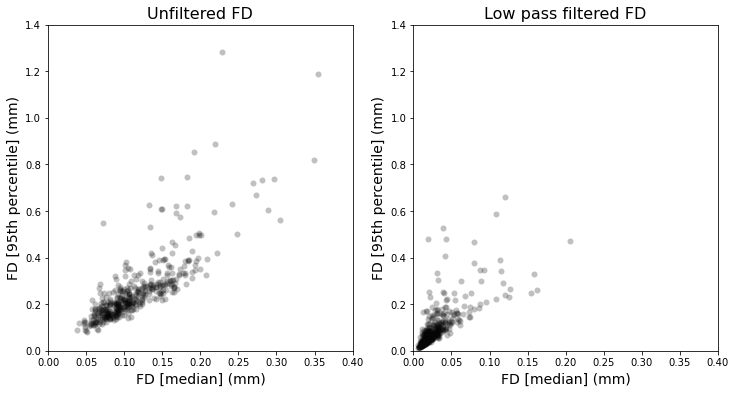

In [69]:
# Scatter plots of FD_p50 vs FD_p95 over all protocols, tasks
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(
    x='FD_p50',
    y='FD_p95',
    data=fd_stats,
    alpha=0.25,
    color='#050505',
    linewidth=0,
    ax=axs[0]
)

axs[0].set_title('Unfiltered FD', fontsize=16)
axs[0].set_xlabel('FD [median] (mm)', fontsize=14)
axs[0].set_ylabel('FD [95th percentile] (mm)', fontsize=14)
axs[0].set_xlim((0, 0.4))
axs[0].set_ylim((0, 1.4))

sns.scatterplot(
    x='FD_LPF_p50',
    y='FD_LPF_p95',
    data=fd_stats,
    alpha=0.25,
    color='#050505',
    linewidth=0,
    ax=axs[1]
)

axs[1].set_title('Low pass filtered FD', fontsize=16)
axs[1].set_xlabel('FD [median] (mm)', fontsize=14)
axs[1].set_ylabel('FD [95th percentile] (mm)', fontsize=14)
axs[1].set_xlim((0, 0.4))
axs[1].set_ylim((0, 1.4))

plt.savefig('Unfiltered_vs_Filtered_FD.png', dpi=300)
plt.show()

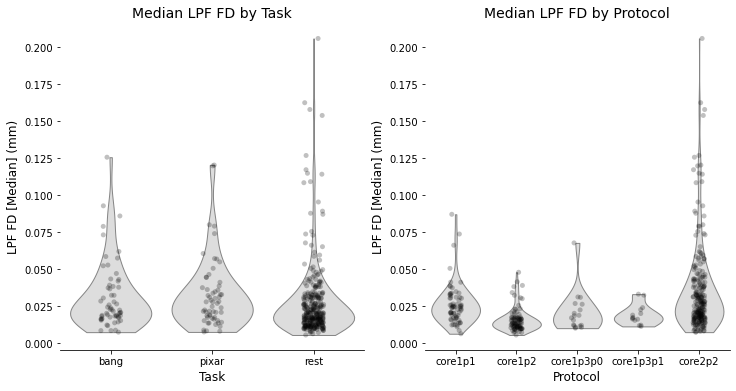

In [70]:
# Violin/Strip plots of median filtered FD by Protocol and Task

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Median FD By Task
# -----------------

ordered = sorted(df['Task'].unique())

sns.violinplot(
    x='Task',
    y='FD_LPF_p50',
    data=fd_stats,
    cut=0,
    scale='width',
    inner=None,
    linewidth=1,
    color='#DDDDDD',
    saturation=1,
    order=ordered,
    ax=axs[0]
)

sns.stripplot(
    x='Task',
    y='FD_LPF_p50',
    data=fd_stats,
    jitter=True,
    linewidth=0,
    order=ordered,
    color='#050505',
    alpha=0.25,
    ax=axs[0]
)

sns.despine(left=True)

axs[0].set_ylabel('LPF FD [Median] (mm)')
axs[0].xaxis.label.set_size(12)
axs[0].yaxis.label.set_size(12)
axs[0].set_title('Median LPF FD by Task', fontsize=14)

# Median FD By Protocol
# ---------------------

ordered = sorted(df['Protocol'].unique())

sns.violinplot(
    x='Protocol',
    y='FD_LPF_p50',
    data=fd_stats,
    cut=0,
    scale='width',
    inner=None,
    linewidth=1,
    color='#DDDDDD',
    saturation=1,
    order=ordered,
    ax=axs[1]
)

sns.stripplot(
    x='Protocol',
    y='FD_LPF_p50',
    data=fd_stats,
    jitter=True,
    linewidth=0,
    order=ordered,
    color='#050505',
    alpha=0.25,
    ax=axs[1]
)

sns.despine(left=True)

axs[1].set_ylabel('LPF FD [Median] (mm)')
axs[1].xaxis.label.set_size(12)
axs[1].yaxis.label.set_size(12)
axs[1].set_title('Median LPF FD by Protocol', fontsize=14)

plt.savefig('Median_LPF_FD_by_Task_Protocol.png', dpi=300)
plt.show()